# Task 1  

## General instructions

First, update the following text to have a link to your Homework 3 GitHub repository:

**UPDATE THIS LINK**
https://github.com/maxwellpatt/eds220-hw-3

Link updated

Add comments for all your code and commit as needed. Err on the side of commenting and commiting too much for now. Points will be deducted for insufficient comments.


## About the data
In this task you will use two datsets:

**First dataset**

The first dataset contains information about [spilling incidents in the state of New York](https://data.ny.gov/Energy-Environment/Spill-Incidents/u44d-k5fk). 
The data portal has plenty of information. 
You will find extra information and metadata for this datset in the 'NYSDEC_SpillIncidents_Overview.pdf' and 'NYSDEC_SpillIncidents_DataDictionary.pdf' documents available at the portal.

You can access this datset via its URL or download it as a csv. 
If you chose to access it via URL, it will take a while to load every time you import it. 

**Second dataset**

The second dataset is a [TIGER shapefile from the United States Census Bureau](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2022.html#list-tab-790442341). 
For this task you will need to **download the 2022 counties (and equivalent) TIGER shapefile**. 
You can check the [metadata for all the TIGER shapefiles here](https://www.census.gov/programs-surveys/geography/technical-documentation/complete-technical-documentation/tiger-geo-line.html). 



## File management
Make sure all your data files are inside a directory named 'data' inside your repository's directory (working directory).

## Datasets description
Read the metadata for both datsets and write a brief description about each once. Indicate the date sources and date of access.


The first dataset we are working with contains information on petrolium (and other hazardous materials) spill occurrences in the state of New York. Spills contaminate land and water and are very harmful to the environment. Columns in the data include program facility name, spill date/time, location, spill source and cause, material(s) and material type spilled, quantity spilled and recovered, units measured, surface water bodies affected, and close date (cleanup activity finished and all paperwork completed). Data is provided by the New York State Department of Environmental Conservation and is updated daily. 

Citation:
New York State Department of Environmental Conservation. (2023, November 9). Spill incidents: State of New York. Spill Incidents | State of New York. https://data.ny.gov/Energy-Environment/Spill-Incidents/u44d-k5fk 

The second dataset is the TIGER data from the United States Cencus Bureau government website. The data provides accessible data on boundary lines on many level, including state and cencus tracts. Accessed November 8, 2023.

## FINAL CODE

You will use the next cell at the end of the task. Leave it blank for now. 

/tmp/ipykernel_1785018/3324034642.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  petr_23['spill_date'] = pd.to_datetime(petr_23['spill_date'])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


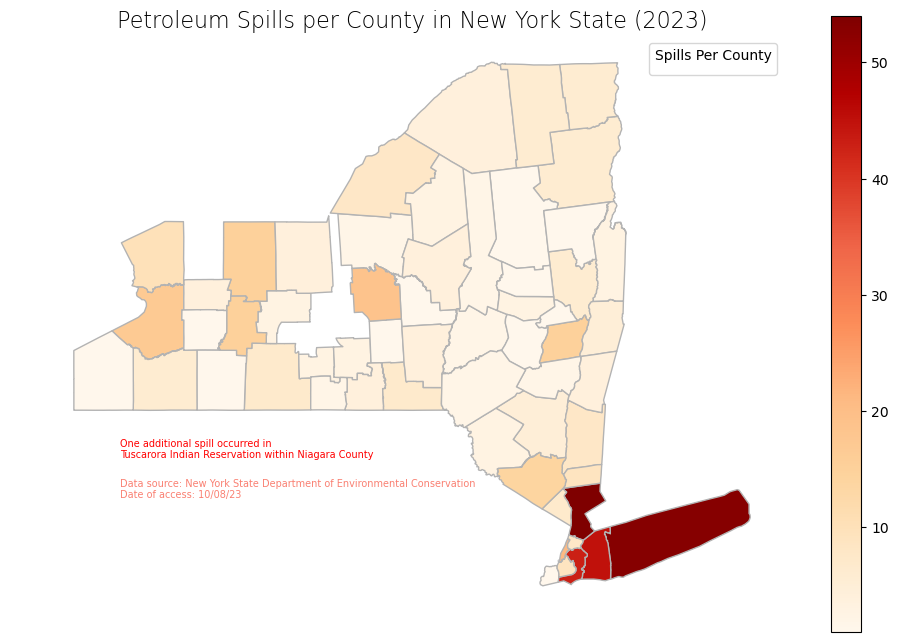

In [23]:
### IMPORT LIBRARIES

import numpy as np
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box

### IMPORT DATA

# import NY spills data using pandas
spills = pd.read_csv('data/Spill_Incidents_20231107.csv')

# import US counties shapefile using geopandas
counties = gpd.read_file('data/tl_2022/tl_2022_us_county.shp')

### PREPARE SPILLS DATA
# convert columns to snake case
spills.columns = spills.columns.str.lower().str.replace(' ','_')

# filter for petroleum spills from 01-01-23 to 10-31-23 and convert date to a datetime
petr_23 = spills[(spills['material_family'] == 'Petroleum') &
                 (pd.to_datetime(spills['spill_date']) >= '2023-01-01') & 
                 (pd.to_datetime(spills['spill_date']) <= '2023-10-31')]

# convert spill_date to a dt
petr_23['spill_date'] = pd.to_datetime(petr_23['spill_date'])

# group petr_23 by county and get the number of spills for each, reset index
spills_per_county = petr_23.groupby('county').size().reset_index()

### PREPARE COUNTIES DATA

# convert column names to snakecase
counties.columns = counties.columns.str.lower().str.replace(' ','_')

# filter for New York counties using the FIPS code
ny_counties = counties[counties['statefp'] == '36']

# we can get the index of that single row like this, to access the actual row index...
spills_per_county[spills_per_county.county=='St Lawrence'].index

# we need to select the first item in that tuple using [0]
st_lawrence_index = spills_per_county[spills_per_county.county=='St Lawrence'].index[0]

# update county column at st_lawrence_index to 'St. Lawrence'
spills_per_county.at[st_lawrence_index, 'county'] = 'St. Lawrence'

### MERGE

# remove 'Yates' from ny_counties since it is not in spills_per_country
ny_counties = ny_counties[ny_counties['name'] != 'Yates']

# remove 'New Jersey - Region 2' from spills_per_county
spills_per_county = spills_per_county[spills_per_county['county'] != 'New Jersey - Region 2']

# rename the columns of the new df
spills_per_county.columns = ['county', 'n_spills']

# perform inner join of datasets
ny_counties = gpd.GeoDataFrame(ny_counties.merge(spills_per_county, how='inner', left_on='name', right_on='county'))

# find index of Niagara county
niagara_index = ny_counties[ny_counties['name'] == 'Niagara'].index[0]

# add one spill to n_spills for Niagara county
ny_counties.at[niagara_index, 'n_spills'] += 1

### MAP

# set map
fig, ax = plt.subplots(figsize =(12,8))

# plot the number of spills by county
ny_counties.plot(ax=ax,
                 column='n_spills',   
                 cmap='OrRd',         
                 legend=True,        
                 edgecolor='0.7')     

# turn axis off
ax.axis('off')

# set title 
ax.set_title('Petroleum Spills per County in New York State (2023)', fontdict={'fontsize': '16', 'fontweight' : '3'})

# add data source
ax.annotate('Data source: New York State Department of Environmental Conservation\nDate of access: 10/08/23',
            xy=(0.1, .18), xycoords='figure fraction', horizontalalignment='left',
            fontsize=7, color='salmon')

# add Tuscarora Indian Reservation annotation
ax.annotate('One additional spill occurred in\nTuscarora Indian Reservation within Niagara County',
            xy=(0.1, .23), xycoords='figure fraction', horizontalalignment='left',
            fontsize=7, color='red')

# set legend title
ax.legend(title='Spills Per County')

# show map
plt.show()


NOTE: Cayuga, Orleans, Seneca counties are not showing up on the map due to data entry issues, likely with Taylor server. This is shown in earlier code, and now can be seen in the white spaces in the map. Yutian confirmed that this is fine since it is almost certainly not a code-related issue. 

<!-- write your description in this markdwon cell -->

## Import libraries

In [2]:
# import libraries
import numpy as np
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
print("Libraries imported!")

Libraries imported!


## Import data 
In the next cell:

- Import the NY spills data as a variable named `spills`. 
- Import the US counties shapefile as a variable named `counties`.


In [3]:
# import NY spills data using pandas
spills = pd.read_csv('data/Spill_Incidents_20231107.csv')

# import US counties shapefile using geopandas
counties = gpd.read_file('data/tl_2022/tl_2022_us_county.shp')
print("Data read in successfully!")


Data read in successfully!


## Prepare spills data

This section refers to the `spills` dataframe. 
Check the outputs carefully, they will give you context about the next exercises.

### Exploration

In the next cells:

1. Check the dataframe's head
2. Simplify column names as needed
3. Check the data types of the columns
4. Check the unique values in the `material_family` column
5. Check the unique values in the `county` column

You can add any other cells of preliminary data exploration.

In [4]:
# check the head of spills using head function
print("Spills head:\n", spills.head(5))


Spills head:
    Spill Number Program Facility Name                  Street 1 Street 2  \
0        107132                MH 864        RT 119/MILLWOOD RD      NaN   
1        405586             BOWRY BAY        WATER POLL CONTROL      NaN   
2        405586             BOWRY BAY        WATER POLL CONTROL      NaN   
3        204667            POLE 16091       GRACE AVE/BURKE AVE      NaN   
4        210559               POLE ON  FERDALE LOMIS RD / RT 52      NaN   

   Locality       County ZIP Code  SWIS Code  DEC Region  Spill Date  \
0  ELMSFORD  Westchester      NaN     6000.0         3.0  10/10/2001   
1    QUEENS       Queens      NaN     4101.0         2.0  08/21/2004   
2    QUEENS       Queens      NaN     4101.0         2.0  08/21/2004   
3     BRONX        Bronx      NaN      301.0         2.0  08/02/2002   
4   LIBERTY     Sullivan      NaN     5336.0         3.0  01/20/2003   

  Received Date Contributing Factor   Waterbody                 Source  \
0    10/10/2001       

In [5]:
# convert columns to snake case
spills.columns = spills.columns.str.lower().str.replace(' ','_')

# display results
print("Column names:\n", spills.columns)

Column names:
 Index(['spill_number', 'program_facility_name', 'street_1', 'street_2',
       'locality', 'county', 'zip_code', 'swis_code', 'dec_region',
       'spill_date', 'received_date', 'contributing_factor', 'waterbody',
       'source', 'close_date', 'material_name', 'material_family', 'quantity',
       'units', 'recovered'],
      dtype='object')


In [66]:
# display the data types of each column
print("Data types of each column:\n", spills.dtypes)

Data types of each column:
 spill_number               int64
program_facility_name     object
street_1                  object
street_2                  object
locality                  object
county                    object
zip_code                  object
swis_code                float64
dec_region               float64
spill_date                object
received_date             object
contributing_factor       object
waterbody                 object
source                    object
close_date                object
material_name             object
material_family           object
quantity                 float64
units                     object
recovered                float64
dtype: object


In [6]:
# display the unique values in the material_family column 
mf_unique = spills['material_family'].unique()

# display results
print("Unique values in the material_family column:\n", mf_unique)

Unique values in the material_family column:
 ['Other' 'Petroleum' 'Hazardous Material' 'Oxygenates' nan]


In [7]:
# display the unique values in the county column
county_unique = spills['county'].unique()

# display results
print("Unique values in the county column:\n", county_unique)

Unique values in the county column:
 ['Westchester' 'Queens' 'Bronx' 'Sullivan' 'Cortland' 'New York' 'Ulster'
 'Kings' 'Orange' 'Dutchess' 'Onondaga' 'Saratoga' 'Cayuga' 'Oswego'
 'Warren' 'Niagara' 'Rockland' 'Nassau' 'Jefferson' 'Schenectady' 'Albany'
 'Monroe' 'St Lawrence' 'Richmond' 'Clinton' 'Lewis' 'Essex' 'Chenango'
 'Erie' 'Livingston' 'Wayne' 'Suffolk' 'Orleans' 'Ontario' 'Genesee'
 'Otsego' 'Tompkins' 'Madison' 'Chemung' 'Seneca' 'Oneida' 'Broome'
 'Hamilton' 'Washington' 'Schuyler' 'Franklin' 'Columbia' 'Fulton'
 'Herkimer' 'Schoharie' 'Rensselaer' 'Montgomery' 'Putnam' 'Delaware'
 'New Jersey - Region 2' 'Steuben' 'Tioga' 'Chautauqua' 'Cattaraugus'
 'Wyoming' 'Yates' 'Greene' 'Pennsylvania - Region 9' 'Allegany'
 'New Jersey - Region 3 (N)' 'Cattaraugus Indian Reservation'
 'New Jersey - Region 3 (T)' nan]


### Data selection

1. Select data about petroleum spills that took place between January 1st 2023, and October 31st (including both dates), 2023. Store it in a variable named `petr_23`. The data selection should occur in a single line. You may add cells if you needed.

In [8]:
# filter for petroleum spills from 01-01-23 to 10-31-23 and convert date to a datetime
petr_23 = spills[(spills['material_family'] == 'Petroleum') &
                 (pd.to_datetime(spills['spill_date']) >= '2023-01-01') & 
                 (pd.to_datetime(spills['spill_date']) <= '2023-10-31')]

2. Verify that `petr_23` only has data for petroleum spills 

In [9]:
# check if Petroleum is the only unique value in the material_family column
only_petroleum = (petr_23['material_family'].unique() == ['Petroleum'])

# dispaly if Petroleum is the only unique vaue in the material_family column as a boolean
print("Petroleum is the only material family:", only_petroleum)


Petroleum is the only material family: [ True]


3. Verify that `petr_23` only has data for 2023. 
HINT: if you converted the `spill_date` column to datetime, you can use `petr_23.spill_date.dt.year.unique()`

In [10]:
# convert spill_date to a dt
petr_23['spill_date'] = pd.to_datetime(petr_23['spill_date'])

# check if all data is from 2023
only_2023 = (petr_23.spill_date.dt.year.unique() == [2023])

# display results whether data is from only 2023
print("All spill dates are in the year 2023:", only_2023)


All spill dates are in the year 2023: [ True]


/tmp/ipykernel_1587065/783478359.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  petr_23['spill_date'] = pd.to_datetime(petr_23['spill_date'])


4. Verify that `petr_23` only has data from January to October. 

In [11]:
# get the unique months in the dataframe
unique_months = petr_23.spill_date.dt.month.unique()

# check if all  months are within January to October 
is_j_to_o = all(month in range(1, 11) for month in unique_months)

# display whether months in the data are in the correct range of January to October
print("All spill dates are from January to October:", is_j_to_o)


All spill dates are from January to October: True


### Data aggregation

Create new dataframe named `spills_per_county` with the number of petroleum spills per county from January to October 2023 (i.e. use the `petr_23` dataframe).

The resulting `spills_per_county` dataframe must be as follows:

- Index: integer numbers starting from 0
- Column one: county names, column name = `county`
- Column two: number of petroleum spills per county in 2023, column name = `n_spills`

You may add cells if you needed.

In [12]:
# group petr_23 by county and get the number of spills for each, reset index
spills_per_county = petr_23.groupby('county').size().reset_index()

# rename the columns of the new df
spills_per_county.columns = ['county', 'n_spills']

# display results
print(spills_per_county)


                   county  n_spills
0                  Albany        15
1                Allegany         1
2                   Bronx         8
3                  Broome         7
4             Cattaraugus         6
5              Chautauqua         1
6                 Chemung         2
7                Chenango         4
8                 Clinton         6
9                Columbia         4
10               Cortland         1
11               Delaware         2
12               Dutchess         8
13                   Erie        17
14                  Essex         6
15               Franklin         6
16                 Fulton         1
17                Genesee         4
18                 Greene         2
19               Hamilton         1
20               Herkimer         2
21              Jefferson         8
22                  Kings         9
23                  Lewis         3
24             Livingston        15
25                Madison         1
26                 Monroe   

## Prepare counties data

This section refers to the `counties` geodataframe. 
Check the outputs carefully, they will give you context about the next exercises.

### Exploration

In the next cells:

1. Check the geo-dataframe's head
2. Simplify column names as needed
3. Check the data types of the columns
4. Check the geo-dataframe's CRS
5. Plot the geo-dataframe.

You can add any other cells of preliminary data exploration.

In [13]:
# check the head of counties
counties.head(5)

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477644346,10691216,+41.9158651,-096.7885168,"POLYGON ((-96.55515 41.91587, -96.55515 41.914..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680980770,61564427,+46.2946377,-123.4244583,"POLYGON ((-123.72755 46.26449, -123.72755 46.2..."
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016818946,29090018,+34.3592729,-104.3686961,"POLYGON ((-104.89337 34.08894, -104.89337 34.0..."
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,None,None,A,2169272978,22847034,+40.7835474,-096.6886584,"POLYGON ((-96.68493 40.52330, -96.69219 40.523..."
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645185,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27370 40.11840, -98.27374 40.122..."


In [13]:
# convert column names to snakecase
counties.columns = counties.columns.str.lower().str.replace(' ','_')

In [75]:
# check datatypes of the columns
counties.dtypes

statefp       object
countyfp      object
countyns      object
geoid         object
name          object
namelsad      object
lsad          object
classfp       object
mtfcc         object
csafp         object
cbsafp        object
metdivfp      object
funcstat      object
aland          int64
awater         int64
intptlat      object
intptlon      object
geometry    geometry
dtype: object

In [16]:
# check the geodataframes CRS
print("CRS:", counties.crs)

CRS: epsg:4269


<AxesSubplot:>

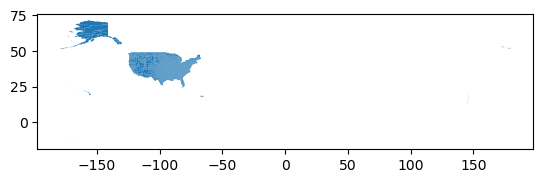

In [76]:
# plot the geodataframe
counties.plot()

### Data selection

Select all the counties for the state of New York in a new variable `ny_counties` and plot them. HINT: to find which counties correspond to NY, look at the metadata.

<AxesSubplot:>

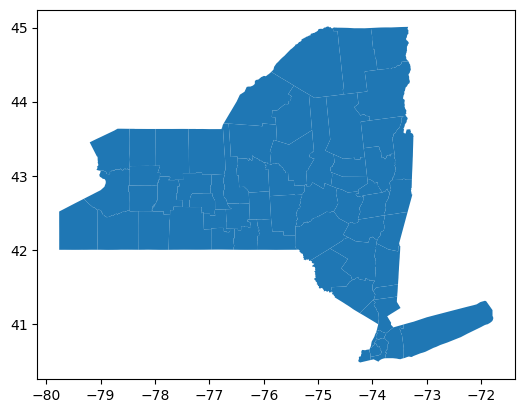

In [14]:
# filter for New York counties using the FIPS code
ny_counties = counties[counties['statefp'] == '36']

# plot the New York counties
ny_counties.plot()


## Merging

The goal of this section is to create a single dataframe with the number of spills per county and the corresponding geometries for each county.

### Explore data

In the next cells:

1. Print the names of counties in `ny_counties`, without repetition.
2. Print the names of counties in `spills_per_county`, without repetition. (Do you notice anything?)
3. Use the [`numpy` function `setdiff1d()`](https://numpy.org/doc/stable/reference/generated/numpy.setdiff1d.html) to find the county names that are in `spills_per_county`, but not in `ny_counties`. HINT: pay attention to the example in the documentation.
4. Find the county names that are in `ny_counties`, but not in `spills_per_county`.
5. Check the number of spills in 'Tuscarora Indian Reservation'.


In [19]:
# print the names of counties in ny_counties using unique() function
print("Unique counties in ny_counties:\n", ny_counties['name'].unique())

Unique counties in ny_counties:
 ['Steuben' 'Saratoga' 'Allegany' 'Oswego' 'Ulster' 'St. Lawrence'
 'Schuyler' 'Essex' 'Suffolk' 'Hamilton' 'Dutchess' 'Otsego' 'Tompkins'
 'Albany' 'Cayuga' 'Greene' 'Herkimer' 'Warren' 'Jefferson' 'Clinton'
 'Nassau' 'Madison' 'Washington' 'Westchester' 'Lewis' 'Ontario'
 'Cortland' 'Richmond' 'Erie' 'Putnam' 'Montgomery' 'Sullivan' 'Orleans'
 'Oneida' 'Cattaraugus' 'Yates' 'Tioga' 'Monroe' 'Schoharie' 'Broome'
 'Rensselaer' 'Seneca' 'Queens' 'Genesee' 'Wayne' 'Niagara' 'Kings'
 'Chemung' 'Wyoming' 'New York' 'Columbia' 'Chautauqua' 'Franklin'
 'Onondaga' 'Chenango' 'Fulton' 'Rockland' 'Livingston' 'Delaware'
 'Orange' 'Schenectady' 'Bronx']


In [20]:
# print the names of counties in spills_per_county using unique() function
print("Unique counties in spills_per_county:\n", spills_per_county['county'].unique())

Unique counties in spills_per_county:
 ['Albany' 'Allegany' 'Bronx' 'Broome' 'Cattaraugus' 'Chautauqua' 'Chemung'
 'Chenango' 'Clinton' 'Columbia' 'Cortland' 'Delaware' 'Dutchess' 'Erie'
 'Essex' 'Franklin' 'Fulton' 'Genesee' 'Greene' 'Hamilton' 'Herkimer'
 'Jefferson' 'Kings' 'Lewis' 'Livingston' 'Madison' 'Monroe' 'Montgomery'
 'Nassau' 'New Jersey - Region 2' 'New York' 'Niagara' 'Oneida' 'Onondaga'
 'Ontario' 'Orange' 'Oswego' 'Otsego' 'Putnam' 'Queens' 'Rensselaer'
 'Richmond' 'Rockland' 'Saratoga' 'Schenectady' 'Schoharie' 'Schuyler'
 'St Lawrence' 'Steuben' 'Suffolk' 'Sullivan' 'Tioga' 'Tompkins' 'Ulster'
 'Warren' 'Washington' 'Wayne' 'Westchester' 'Wyoming']


In [15]:
# use setdif1d to find county names in spills_per_county and not ny_counties
diff = np.setdiff1d(spills_per_county['county'], ny_counties['name'])

# display results
print("Counties in spills_per_county but not ny_counties", diff)

Counties in spills_per_county but not ny_counties ['New Jersey - Region 2' 'St Lawrence']


In [16]:
# use setdif1d to find county names in ny_counties and not spills_per_county 
diff = np.setdiff1d(ny_counties['name'], spills_per_county['county'])

# display results
print("Counties in spills_per_county but not ny_counties", diff)

Counties in spills_per_county but not ny_counties ['Cayuga' 'Orleans' 'Seneca' 'St. Lawrence' 'Yates']


In [17]:
# check number of spills in Tuescarora 
# find this data cell
tuscarora_spills = spills_per_county[spills_per_county['county'] == 'Tuscarora Indian Reservation']['n_spills']

# display results
if not tuscarora_spills.empty:
    print("Number of spills in Tuscarora Indian Reservation:")
    print(tuscarora_spills.iloc[0])
else:
    print("Oops! Tuscarora Indian Reservation not in spills_per_county.")


Oops! Tuscarora Indian Reservation not in spills_per_county.


### Data updates

In this section we will update 'St Lawrence' to 'St. Lawrence' in `spills_per_county` data frame.

In the next cells:
1. Check the row in `spills_per_county` that has 'St Lawrence'
2. Run the code and read the explanation in the comments
3. Run the code and read the explanation in the comments
4. Use the `st_lawrence_index` and `at` to update St Lawrence name in `spills_per_county` dataframe
5. Check the update was successfull

In [18]:
# find the row of 'St Lawrence' in spills_per_county
print(spills_per_county[spills_per_county['county'] == 'St Lawrence'])


         county  n_spills
47  St Lawrence         4


In [19]:
# 2. we can get the index of that single row like this, to access the actual row index...
spills_per_county[spills_per_county.county=='St Lawrence'].index

Int64Index([47], dtype='int64')

In [20]:
# 3. we need to select the first item in that tuple using [0]
st_lawrence_index = spills_per_county[spills_per_county.county=='St Lawrence'].index[0]

# display results
st_lawrence_index

47

In [21]:
# update county column at st_lawrence_index to 'St. Lawrence'
spills_per_county.at[st_lawrence_index, 'county'] = 'St. Lawrence'

In [22]:
# check that the update to 'St. Lawrence' worked
print(spills_per_county.loc[st_lawrence_index])

county      St. Lawrence
n_spills               4
Name: 47, dtype: object


### Merge

In the following cells:
1. Use this cell to make any other updates needed for making an inner join of the `spills_per_county` and `ny_counties`. 
2. Over-write `ny_counties` as the  inner join of the `spills_per_county` and `ny_counties` dataframes.

From our previous exploration we know that Tuscarora Indian Reservation will not be in the join. Tuscarora Indian Reservation is located within Niagara county. 

3. Since the Tuscarora Indian Reservation does not appear in the `ny_counties` dataframe, add one spill to Niagara county. We will add a note about this in our final map. Add the cells you need to make this update **and** verify that the dataframe was updated.

In [23]:
# remove 'Yates' from ny_counties since it is not in spills_per_country
ny_counties = ny_counties[ny_counties['name'] != 'Yates']

# remove 'New Jersey - Region 2' from spills_per_county
spills_per_county = spills_per_county[spills_per_county['county'] != 'New Jersey - Region 2']

# sort and get unique values for both datasets
ny_counties_organized = sorted(ny_counties['name'].unique())
spills_per_county_organized = sorted(spills_per_county['county'].unique())

# Compare the sorted unique values
print("Dataset have the same counties:", ny_counties_organized == spills_per_county_organized)

Dataset have the same counties: False


In [24]:
# perform inner join of datasets
ny_counties = gpd.GeoDataFrame(spills_per_county.merge(ny_counties, how='inner', left_on='county', right_on='name'))


In [25]:
# find index of Niagara county
niagara_index = ny_counties[ny_counties['name'] == 'Niagara'].index[0]

# add one spill to n_spills for Niagara county
ny_counties.at[niagara_index, 'n_spills'] += 1

# confirm results
new_spills = ny_counties.loc[niagara_index, 'n_spills']
print("Updated number of spills for Niagara county:", new_spills)


Updated number of spills for Niagara county: 10


## Map
Create a choropleth map of the number of petroleum spills per county in the state of New York in 2023. 
Your map should have (at least) the following updates:
- a legend indicating the number of spills
- an updated color map
- a title 
- no axis
- an annotation with the data source (New York State Department of Environmental Conservation), date of access HINT: check the graph we did for power plants, 
- an annotation indicating one spill occurred in Tuscarora Indian Reservation within Niagara county

Tuscarora Indian Reservation in Niagara county

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


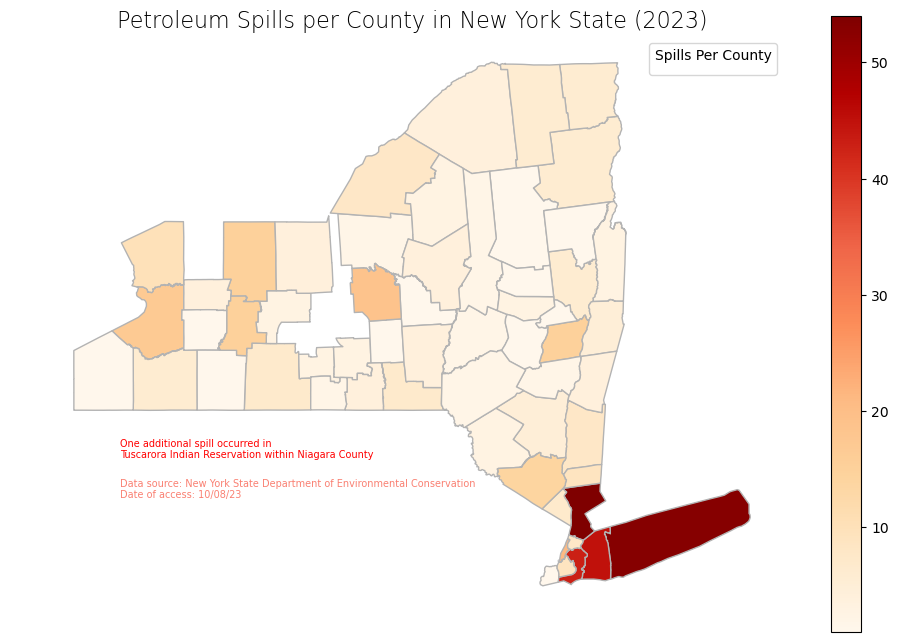

In [26]:
# set plot
fig, ax = plt.subplots(figsize =(12,8))

# plot the number of spills by county
ny_counties.plot(ax=ax,
                 column='n_spills',   
                 cmap='OrRd',         
                 legend=True,        
                 edgecolor='0.7')     

# turn axis off
ax.axis('off')

# set title 
ax.set_title('Petroleum Spills per County in New York State (2023)', fontdict={'fontsize': '16', 'fontweight' : '3'})

# add data source
ax.annotate('Data source: New York State Department of Environmental Conservation\nDate of access: 10/08/23',
            xy=(0.1, .18), xycoords='figure fraction', horizontalalignment='left',
            fontsize=7, color='salmon')

# add Tuscarora Indian Reservation annotation
ax.annotate('One additional spill occurred in\nTuscarora Indian Reservation within Niagara County',
            xy=(0.1, .23), xycoords='figure fraction', horizontalalignment='left',
            fontsize=7, color='red')

# set legend title 
ax.legend(title='Spills Per County')

# show map
plt.show()


NOTE: Cayuga, Orleans, Seneca counties are not showing up on the map due to data entry issues, likely with Taylor server. This is shown in earlier code, and now can be seen in the white spaces in the map. Yutian confirmed that this is fine since it is almost certainly not a code-related issue. 

## Final code

Collect all the relevant code into the first blank cell of the notebook titled "FINAL CODE". This single cell will have the end-to-end workflow: from importing libraries and loading the data, to producing the graph. The *only* ouput of this cell should be the graph you produced in the previous exercise. For each line, add a single comment explaining what the code does.